# 📊 Notebook 2: DBSCAN Classification (FIXED)

## 🎯 Purpose
Use DBSCAN to identify DEAD STOCK and NEW ITEMS, then KMeans to classify remaining items as FAST/SLOW movers.

## 🔧 FIX: Correct Classification Logic
**Problem**: Original logic incorrectly assumed cluster -1 = dead stock

**Solution**: Use actual metrics regardless of cluster ID:
- **DEAD_STOCK**: days_since_last_sale >= 180 AND transaction_count <= 5
- **NEW_ITEM**: days_since_creation <= 90 AND transaction_count <= 30
- **ACTIVE**: Everything else → classify with KMeans

## 📥 Input
- **File**: `master_inventory_data.csv` (from Notebook 1)

## 📤 Output
- **File**: `dbscan_classification.csv` ⭐ (Main classification file)
- **File**: All other output files...

In [20]:
# 📚 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import pickle
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1️⃣ Load Master Data

In [21]:
try:
    print("⏳ Loading master data from pickle...")
    df = pd.read_pickle('/tmp/master_inventory_data.pkl')
    print("✅ Loaded from pickle")
except FileNotFoundError:
    print("⏳ Pickle not found, loading from CSV...")
    df = pd.read_csv('/tmp/master_inventory_data.csv')
    print("✅ Loaded from CSV")

print(f"\n📊 Dataset Info:")
print(f"   Total items: {len(df):,}")
print(f"   Total columns: {len(df.columns)}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

⏳ Loading master data from pickle...
✅ Loaded from pickle

📊 Dataset Info:
   Total items: 13,489
   Total columns: 71
   Memory usage: 11.00 MB


#### 📦 Inventory Classification Logic — Business Rule Engine

This rule-based engine classifies inventory items into four lifecycle stages using sales recency, item age, and movement velocity.

---

##### 🔹 Classification Priority Order
Rules are evaluated in the following order:

1. NEW_ITEM  
2. DEAD_STOCK  
3. DORMANT  
4. ACTIVE  

---

####  NEW_ITEM — Launch Phase

An item is classified as **NEW_ITEM** if:

- `days_since_creation ≤ 90`  
  **OR**
- `days_since_first_activity ≤ 90`

> These items are still in the introduction phase and do not yet have enough sales history for performance evaluation.

---

####  DEAD_STOCK — Obsolete / Non-Moving

An item is classified as **DEAD_STOCK** if:

- `days_since_last_sale ≥ 730`  
  *(no sales for 2+ years)*  
  **OR**
- `transaction_count = 0 AND days_since_creation > 730`  
  *(never sold in 2+ years)*

> These items have lost business relevance and should be considered for liquidation or write-off.

---

#### DORMANT — At-Risk Inventory

An item is classified as **DORMANT** if **any** of the following is true:

- `days_since_last_sale ≥ 365`  
  *(no sale for 1+ year)*  
- `velocity_90d < 0.005 units/day`  
  *(near-zero movement)*  
- `transaction_count ≤ 2`  
  *(very low demand history)*  

> These items are not dead yet but represent capital risk and require corrective action.

---

#### ACTIVE — Revenue Generating

An item is classified as **ACTIVE** if:

- It is not NEW_ITEM  
- It is not DEAD_STOCK  
- It is not DORMANT  

> These are your core business items that justify replenishment and forecasting.

---

#### Business Interpretation

| Class      | Meaning              | Recommended Action            |
|------------|---------------------|-----------------------------|
| NEW_ITEM   | Early lifecycle     | Monitor demand              |
| ACTIVE     | Normal movement     | Forecast & replenish        |
| DORMANT    | Risk zone           | Reduce stock, promote       |
| DEAD_STOCK | Obsolete inventory  | Liquidate / write-off       |

---


In [29]:
def classify_item(row):
    days_no_sale = row['days_since_last_sale']
    days_old = row['days_since_creation']
    transaction_count = row['transaction_count']
    days_since_first_activity = row['days_since_first_activity']
    velocity = row['velocity_90d']

    # NEW ITEMS
    if days_old <= 90 or days_since_first_activity <= 90:
        return 'NEW_ITEM'

    # DEAD STOCK
    if (days_no_sale >= 730) or (transaction_count == 0 and days_old > 730):
        return 'DEAD_STOCK'

    # DORMANT (risk zone)
    if days_no_sale >= 365 or velocity < 0.005 or transaction_count <= 2:
        return 'DORMANT'

    # ACTIVE
    return 'ACTIVE'

# Apply fixed classification
print("⏳ Applying rule-based classification...\n")
df['initial_classification'] = df.apply(classify_item, axis=1)

print("✅ Rule-based classification complete")
print(f"\n📊 INITIAL CLASSIFICATION (Rule-Based):\n")
print(df['initial_classification'].value_counts())
print()

for cls in ['DEAD_STOCK', 'NEW_ITEM', 'DORMANT', 'ACTIVE']:
    subset = df[df['initial_classification'] == cls]
    if len(subset) > 0:
        count = len(subset)
        value = subset['stock_value'].sum()
        pct = count / len(df) * 100
        
        avg_days_no_sale = subset['days_since_last_sale'].mean()
        avg_age = subset['days_since_creation'].mean()
        avg_velocity = subset['velocity_90d'].mean()
        avg_transactions = subset['transaction_count'].mean()
        
        print(f"{cls:15s}: {count:5,} items ({pct:5.1f}%)")
        print(f"   Stock Value: {value:,.0f}")
        print(f"   Avg days no sale: {avg_days_no_sale:.1f}")
        print(f"   Avg age: {avg_age:.1f} days")
        print(f"   Avg velocity: {avg_velocity:.3f} units/day")
        print(f"   Avg transactions: {avg_transactions:.1f}")
        print()

⏳ Applying rule-based classification...

✅ Rule-based classification complete

📊 INITIAL CLASSIFICATION (Rule-Based):

initial_classification
DEAD_STOCK    10203
DORMANT        2742
NEW_ITEM        333
ACTIVE          211
Name: count, dtype: int64

DEAD_STOCK     : 10,203 items ( 75.6%)
   Stock Value: 976,134
   Avg days no sale: 999.5
   Avg age: 772.9 days
   Avg velocity: 0.000 units/day
   Avg transactions: 0.1

NEW_ITEM       :   333 items (  2.5%)
   Stock Value: 64,672
   Avg days no sale: 493.6
   Avg age: 108.2 days
   Avg velocity: 0.017 units/day
   Avg transactions: 0.6

DORMANT        : 2,742 items ( 20.3%)
   Stock Value: 1,193,950
   Avg days no sale: 348.7
   Avg age: 702.4 days
   Avg velocity: 0.001 units/day
   Avg transactions: 3.0

ACTIVE         :   211 items (  1.6%)
   Stock Value: 834,910
   Avg days no sale: 51.3
   Avg age: 1087.7 days
   Avg velocity: 0.146 units/day
   Avg transactions: 16.9



## 3️⃣ DBSCAN for Additional Insights (Optional)

### Use DBSCAN to validate and find sub-groups within ACTIVE items

In [38]:
# Still run DBSCAN for clustering insights
dbscan_features = [
    'days_since_last_sale',
    'days_since_creation',
    'velocity_90d',
    'transaction_count',
    'days_of_stock'
]

X_dbscan = df[dbscan_features].copy()
X_dbscan = X_dbscan.replace([np.inf, -np.inf], np.nan)
X_dbscan = X_dbscan.fillna({
    'days_since_last_sale': 999,
    'days_since_creation': X_dbscan['days_since_creation'].median(),
    'velocity_90d': 0,
    'transaction_count': 0,
    'days_of_stock': 999
})

scaler_dbscan = StandardScaler()
X_dbscan_scaled = scaler_dbscan.fit_transform(X_dbscan)

# Run DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=10, metric='euclidean')
df['dbscan_cluster'] = dbscan.fit_predict(X_dbscan_scaled)

print("✅ DBSCAN clustering complete (for reference)")
print(f"\n📊 DBSCAN found {len(df['dbscan_cluster'].unique())} clusters")
print("   (This is used for validation, not for classification)")

✅ DBSCAN clustering complete (for reference)

📊 DBSCAN found 2 clusters
   (This is used for validation, not for classification)


## 4️⃣ Prepare Features for KMeans (Active Items Only)

In [51]:
pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 6.8 MB/s eta 0:00:00? eta -:--:--
  Installing build dependenciedone
  Getting requirements to build wheel ... one
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp313-cp313-macosx_11_0_arm64.whl size=367498 sha256=81386a81dcd43d0e34b7bca5ca04e344696d6e3d8262b2d8d8309bd3fdc5709f
  Stored in directory: /Users/sanikacs/Library/Caches/pip/wheels/17/4b/b8/6b6711681d0981b110c9cc91ad6d1ebd88adf1547e1da301fc
Successfully built scikit-learn-extra
Note: you may need to restart the kernel to use updated packages.


In [52]:
from sklearn_extra.cluster import KMedoids

In [53]:
# Filter active items for KMeans
active_items = df[(df['initial_classification'] == 'ACTIVE') | 
                  (df['initial_classification'] == 'DORMANT')].copy()


print(f"\n📊 ACTIVE ITEMS for KMeans Classification:")
print(f"   Total: {len(active_items):,} items")

if len(active_items) < 10:
    print("\n⚠️ Too few active items for KMeans clustering")
    print("   All active items will be classified as MEDIUM movers")
    df.loc[df['initial_classification'] == 'ACTIVE', 'final_classification'] = 'MEDIUM'
else:
    # Select features for KMeans
    kmeans_features = [
        'velocity_30d',
        'velocity_90d',
        'transaction_frequency',
        'revenue_per_unit',
        'customer_concentration'
    ]
    
    X_kmeans = active_items[kmeans_features].copy()
    X_kmeans = X_kmeans.fillna({
        'velocity_30d': 0,
        'velocity_90d': 0,
        
        'transaction_frequency': 0,
        'revenue_per_unit': X_kmeans['revenue_per_unit'].median(),
        'customer_concentration': 0
    })
    
    print(f"\n✅ Features prepared for KMeans")
    print(f"   Shape: {X_kmeans.shape}")


📊 ACTIVE ITEMS for KMeans Classification:
   Total: 2,953 items

✅ Features prepared for KMeans
   Shape: (2953, 5)


## 5️⃣ Run KMeans Clustering

In [60]:
from sklearn.preprocessing import RobustScaler
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

if len(active_items) >= 10:

    # -----------------------------
    # 1. Feature Scaling (Robust)
    # -----------------------------
    scaler_kmedoids = RobustScaler()
    X_kmedoids_scaled = scaler_kmedoids.fit_transform(X_kmeans)

    print("✅ Features scaled for KMedoids (RobustScaler)")

    # -----------------------------
    # 2. Run KMedoids (K = 4)
    # -----------------------------
    print("\n⏳ Running KMedoids clustering (K=4)...\n")

    kmedoids = KMedoids(
        n_clusters=4,
        random_state=42,
        method='pam',
        metric='euclidean'
    )

    active_items['kmedoids_cluster'] = kmedoids.fit_predict(X_kmedoids_scaled)

    # -----------------------------
    # 3. Evaluate clustering quality
    # -----------------------------
    silhouette = silhouette_score(X_kmedoids_scaled, active_items['kmedoids_cluster'])
    davies_bouldin = davies_bouldin_score(X_kmedoids_scaled, active_items['kmedoids_cluster'])

    print("✅ KMedoids clustering complete")
    print(f"\n📊 Clustering Quality:")
    print(f"   Silhouette Score     : {silhouette:.3f}")
    print(f"   Davies-Bouldin Index : {davies_bouldin:.3f}")

    print(f"\n📦 Cluster distribution:")
    print(active_items['kmedoids_cluster'].value_counts().sort_index())

    # -----------------------------
    # 4. Show actual medoids
    # -----------------------------
    print("\n🎯 Cluster Medoids (actual SKUs):")
    medoid_indices = kmedoids.medoid_indices_
    print(active_items.iloc[medoid_indices][['item_code', 'velocity_90d', 'transaction_frequency', 'revenue_per_unit']])


    # -----------------------------
    # 5. Cluster statistics
    # -----------------------------
    cluster_stats = active_items.groupby('kmedoids_cluster').agg({
        'velocity_90d': 'mean',
        'transaction_frequency': 'mean',
        'revenue_per_unit': 'mean',
        'item_code': 'count'
    }).round(3)

    cluster_stats.columns = ['Avg_Velocity', 'Avg_Trans_Freq', 'Avg_Revenue', 'Item_Count']

    print("\n📊 4-CLUSTER KMEDOIDS ANALYSIS:\n")
    print(cluster_stats)

    # -----------------------------
    # 6. Rank clusters by velocity
    # -----------------------------
    sorted_clusters = cluster_stats.sort_values(
        by=['Avg_Velocity', 'Avg_Trans_Freq'], 
        ascending=[False, False]
    ).index.tolist()

    # -----------------------------
    # 7. Assign business tiers
    # -----------------------------
    tier_labels = ['FAST', 'MEDIUM', 'SLOW', 'STAGNANT']
    classification_map = dict(zip(sorted_clusters, tier_labels))

    print("\n🎯 4-Tier Classification:")
    for cluster_id in sorted_clusters:
        row = cluster_stats.loc[cluster_id]
        print(f"   Cluster {cluster_id} → {classification_map[cluster_id]:<8} "
              f"(Vel: {row['Avg_Velocity']:.3f}, Freq: {row['Avg_Trans_Freq']:.3f})")

    # -----------------------------
    # 8. Assign labels to dataframe
    # -----------------------------
    active_items['final_classification'] = active_items['kmedoids_cluster'].map(classification_map)

    df.loc[active_items.index, 'kmedoids_cluster'] = active_items['kmedoids_cluster']
    df.loc[active_items.index, 'final_classification'] = active_items['final_classification']

    print("\n✅ 4-Cluster classification complete (FAST → STAGNANT)")


✅ Features scaled for KMedoids (RobustScaler)

⏳ Running KMedoids clustering (K=4)...

✅ KMedoids clustering complete

📊 Clustering Quality:
   Silhouette Score     : 0.508
   Davies-Bouldin Index : 0.884

📦 Cluster distribution:
kmedoids_cluster
0     237
1      39
2     650
3    2027
Name: count, dtype: int64

🎯 Cluster Medoids (actual SKUs):
        item_code  velocity_90d  transaction_frequency  revenue_per_unit
12343  U250402006          0.00                   0.01           1420.00
404     501000042          0.01                   0.00           8862.86
299     400000141          0.00                   0.01             65.00
12286  U250303001          0.00                   0.00             90.00

📊 4-CLUSTER KMEDOIDS ANALYSIS:

                  Avg_Velocity  Avg_Trans_Freq  Avg_Revenue  Item_Count
kmedoids_cluster                                                       
0                         0.01            0.01      1652.22         237
1                         0.01         

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score

if len(active_items) >= 10:
    # Scale features
    scaler_kmedoids = StandardScaler()
    X_kmedoids_scaled = scaler_kmedoids.fit_transform(X_kmeans)  # assuming X_kmeans is your feature matrix
    
    print("✅ Features scaled for KMedoids")
    
    # Run KMedoids with K=4
    print("\n⏳ Running KMedoids clustering (K=3)...\n")
    
    kmedoids = KMedoids(
        n_clusters=4,
        random_state=42,
        method='pam',      # PAM is classic K-Medoids
        metric='euclidean' # can be changed to 'manhattan' if preferred
    )
    
    active_items['kmedoids_cluster'] = kmedoids.fit_predict(X_kmedoids_scaled)
    
    # Evaluate clustering quality
    silhouette = silhouette_score(X_kmedoids_scaled, active_items['kmedoids_cluster'])
    davies_bouldin = davies_bouldin_score(X_kmedoids_scaled, active_items['kmedoids_cluster'])
    
    print("✅ KMedoids clustering complete")
    print(f"\n📊 Clustering Quality:")
    print(f"   Silhouette Score: {silhouette:.3f}")
    print(f"   Davies-Bouldin Index: {davies_bouldin:.3f}")
    
    print(f"\n   Cluster distribution:")
    print(active_items['kmedoids_cluster'].value_counts())
    
    # Optional: print medoids
    print(f"\n   Cluster Medoids (actual points):")
    print(kmedoids.cluster_centers_)


✅ Features scaled for KMedoids

⏳ Running KMedoids clustering (K=3)...

✅ KMedoids clustering complete

📊 Clustering Quality:
   Silhouette Score: 0.706
   Davies-Bouldin Index: 0.527

   Cluster distribution:
kmedoids_cluster
1    2165
0     740
2      44
3       4
Name: count, dtype: int64

   Cluster Medoids (actual points):
[[-5.25726408e-02 -8.17516894e-02  1.95757464e-01 -1.78254882e-01
  -1.48771956e+00]
 [-5.25726408e-02 -8.17516894e-02 -2.36589836e-01 -1.88569681e-01
   5.73986717e-01]
 [-5.25726408e-02 -8.17516894e-02  7.94231378e-02  5.30921809e+00
   5.73986717e-01]
 [ 2.56518795e+01  2.32289765e+01 -7.35975548e-03 -2.57205561e-01
   5.73986717e-01]]


## 6️⃣ Assign FAST vs SLOW Labels

In [59]:
if len(active_items) >= 10:
    # 1. Update the number of clusters to 4
    # (Ensure you have already initialized your kmedoids model with n_clusters=4)
    # kmeans = KMeans(n_clusters=4, ...) OR kmedoids = KMedoids(n_clusters=4, ...)
    
    # 2. Analyze clusters
    cluster_stats = active_items.groupby('kmedoids_cluster').agg({
        'velocity_90d': 'mean',
        'transaction_frequency': 'mean',
        'revenue_per_unit': 'mean',
        'item_code': 'count'
    }).round(2)
    
    cluster_stats.columns = ['Avg_Velocity', 'Avg_Trans_Freq', 'Avg_Revenue', 'Item_Count']
    
    print("\n📊 4-CLUSTER KMEDOIDS ANALYSIS:\n")
    print(cluster_stats)
    
    # 3. Rank clusters by velocity (highest velocity first)
    sorted_clusters = cluster_stats['Avg_Velocity'].sort_values(ascending=False).index.tolist()
    
    # 4. Assign 4 classifications
    # We use: FAST -> MEDIUM -> SLOW -> STAGNANT
    classification_map = {
        sorted_clusters[0]: 'FAST',
        sorted_clusters[1]: 'MEDIUM',
        sorted_clusters[2]: 'SLOW',
        sorted_clusters[3]: 'STAGNANT'
    }
    
    print(f"\n🎯 4-Tier Classification:")
    for cluster, label in classification_map.items():
        v = cluster_stats.loc[cluster, 'Avg_Velocity']
        f = cluster_stats.loc[cluster, 'Avg_Trans_Freq']
        print(f"   Cluster {cluster} → {label:<8} (Vel: {v:.3f}, Freq: {f:.3f})")
    
    # 5. Assign labels back to dataframes
    active_items['final_classification'] = active_items['kmedoids_cluster'].map(classification_map)
    
    # Update main dataframe
    df.loc[active_items.index, 'kmedoids_cluster'] = active_items['kmedoids_cluster']
    df.loc[active_items.index, 'final_classification'] = active_items['final_classification']
    
    print(f"\n✅ 4-Cluster classification complete (STAGNANT tier added)")


📊 4-CLUSTER KMEDOIDS ANALYSIS:

                  Avg_Velocity  Avg_Trans_Freq  Avg_Revenue  Item_Count
kmedoids_cluster                                                       
0                         0.03            0.01       262.16         740
1                         0.00            0.00       226.67        2165
2                         0.01            0.01      9887.87          44
3                         3.42            0.01         6.45           4

🎯 4-Tier Classification:
   Cluster 3 → FAST     (Vel: 3.420, Freq: 0.010)
   Cluster 0 → MEDIUM   (Vel: 0.030, Freq: 0.010)
   Cluster 2 → SLOW     (Vel: 0.010, Freq: 0.010)
   Cluster 1 → STAGNANT (Vel: 0.000, Freq: 0.000)

✅ 4-Cluster classification complete (STAGNANT tier added)


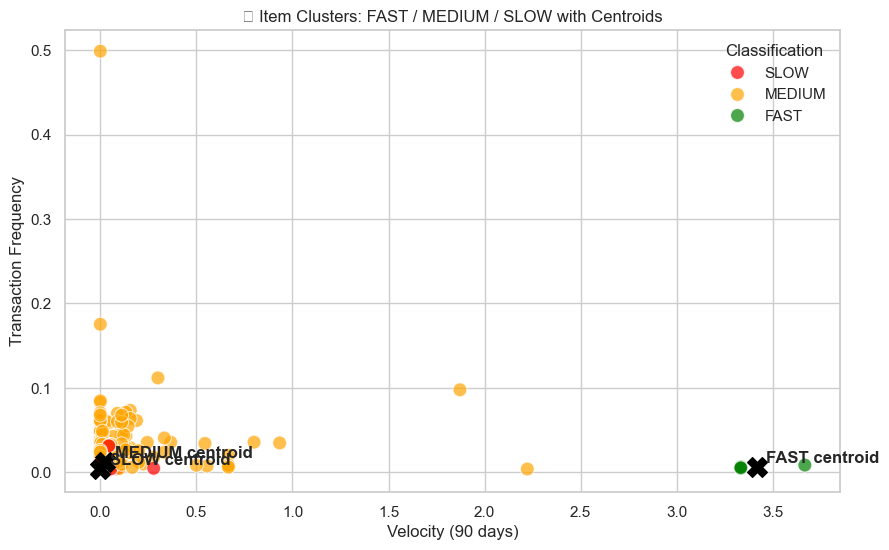

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate centroids
centroids = active_items.groupby('final_classification')[['velocity_90d', 'transaction_frequency']].mean()

# Set style
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=active_items,
    x='velocity_90d',
    y='transaction_frequency',
    hue='final_classification',
    palette={'FAST':'green', 'MEDIUM':'orange', 'SLOW':'red'},
    s=100,
    alpha=0.7
)

# Annotate centroids
for label, row in centroids.iterrows():
    plt.scatter(row['velocity_90d'], row['transaction_frequency'], color='black', s=200, marker='X')  # centroid marker
    plt.text(row['velocity_90d']+0.05, row['transaction_frequency']+0.005, f"{label} centroid", 
             fontsize=12, fontweight='bold')

plt.title("📊 Item Clusters: FAST / MEDIUM / SLOW with Centroids")
plt.xlabel("Velocity (90 days)")
plt.ylabel("Transaction Frequency")
plt.legend(title='Classification')
plt.show()



## 7️⃣ Create Final Classification Column

In [34]:
# Combine all classifications
df['classification'] = df.apply(
    lambda x: x['final_classification'] if pd.notna(x['final_classification']) 
    else x['initial_classification'],
    axis=1
)

# Add is_outlier flag (for reference)
df['is_outlier'] = df['dbscan_cluster'] == -1

print("\n" + "="*100)
print("📊 FINAL CLASSIFICATION RESULTS (FIXED)")
print("="*100)

print(f"\n🎯 Classification Distribution:\n")
print(df['classification'].value_counts())
print()

# Detailed breakdown
for cls in ['DEAD_STOCK', 'NEW_ITEM', 'FAST', 'SLOW', 'MEDIUM']:
    subset = df[df['classification'] == cls]
    if len(subset) > 0:
        count = len(subset)
        value = subset['stock_value'].sum()
        pct = count / len(df) * 100
        
        avg_velocity = subset['velocity_90d'].mean()
        avg_transactions = subset['transaction_count'].mean()
        avg_days_no_sale = subset['days_since_last_sale'].mean()
        
        print(f"{cls:15s}: {count:5,} items ({pct:5.1f}%)")
        print(f"   Stock Value: ₹{value:,.0f}")
        print(f"   Avg Velocity: {avg_velocity:.3f} units/day")
        print(f"   Avg Transactions: {avg_transactions:.1f}")
        print(f"   Avg Days No Sale: {avg_days_no_sale:.1f}")
        print()

print("="*100)


📊 FINAL CLASSIFICATION RESULTS (FIXED)

🎯 Classification Distribution:

classification
DEAD_STOCK    10203
DORMANT        2742
NEW_ITEM        333
SLOW            208
FAST              3
Name: count, dtype: int64

DEAD_STOCK     : 10,203 items ( 75.6%)
   Stock Value: ₹976,134
   Avg Velocity: 0.000 units/day
   Avg Transactions: 0.1
   Avg Days No Sale: 999.5

NEW_ITEM       :   333 items (  2.5%)
   Stock Value: ₹64,672
   Avg Velocity: 0.017 units/day
   Avg Transactions: 0.6
   Avg Days No Sale: 493.6

FAST           :     3 items (  0.0%)
   Stock Value: ₹20,879
   Avg Velocity: 3.444 units/day
   Avg Transactions: 5.7
   Avg Days No Sale: 27.0

SLOW           :   208 items (  1.5%)
   Stock Value: ₹814,031
   Avg Velocity: 0.098 units/day
   Avg Transactions: 17.1
   Avg Days No Sale: 51.6



## 8️⃣ Validation: Check Classification Accuracy

In [35]:
print("\n🔍 VALIDATION CHECKS:\n")
print("="*100)

# Check 1: Dead stock should have no recent sales
dead_stock = df[df['classification'] == 'DEAD_STOCK']
print(f"\n✅ Check 1: DEAD_STOCK validation")
print(f"   Items: {len(dead_stock):,}")
print(f"   Avg days since last sale: {dead_stock['days_since_last_sale'].mean():.1f}")
print(f"   % with 180+ days no sale: {(dead_stock['days_since_last_sale'] >= 180).mean() * 100:.1f}%")
print(f"   Avg velocity: {dead_stock['velocity_90d'].mean():.4f} units/day")

# Check 2: New items should be young
new_items = df[df['classification'] == 'NEW_ITEM']
if len(new_items) > 0:
    print(f"\n✅ Check 2: NEW_ITEM validation")
    print(f"   Items: {len(new_items):,}")
    print(f"   Avg age: {new_items['days_since_creation'].mean():.1f} days")
    print(f"   % under 90 days old: {(new_items['days_since_creation'] <= 90).mean() * 100:.1f}%")
    print(f"   Avg transactions: {new_items['transaction_count'].mean():.1f}")

# Check 3: FAST should be faster than SLOW
fast_items = df[df['classification'] == 'FAST']
slow_items = df[df['classification'] == 'SLOW']

if len(fast_items) > 0 and len(slow_items) > 0:
    print(f"\n✅ Check 3: FAST vs SLOW validation")
    print(f"   FAST avg velocity: {fast_items['velocity_90d'].mean():.3f} units/day")
    print(f"   SLOW avg velocity: {slow_items['velocity_90d'].mean():.3f} units/day")
    print(f"   Ratio (FAST/SLOW): {fast_items['velocity_90d'].mean() / slow_items['velocity_90d'].mean():.2f}x")

print("\n" + "="*100)


🔍 VALIDATION CHECKS:


✅ Check 1: DEAD_STOCK validation
   Items: 10,203
   Avg days since last sale: 999.5
   % with 180+ days no sale: 100.0%
   Avg velocity: 0.0000 units/day

✅ Check 2: NEW_ITEM validation
   Items: 333
   Avg age: 108.2 days
   % under 90 days old: 78.4%
   Avg transactions: 0.6

✅ Check 3: FAST vs SLOW validation
   FAST avg velocity: 3.444 units/day
   SLOW avg velocity: 0.098 units/day
   Ratio (FAST/SLOW): 35.17x



## 9️⃣ Visualizations

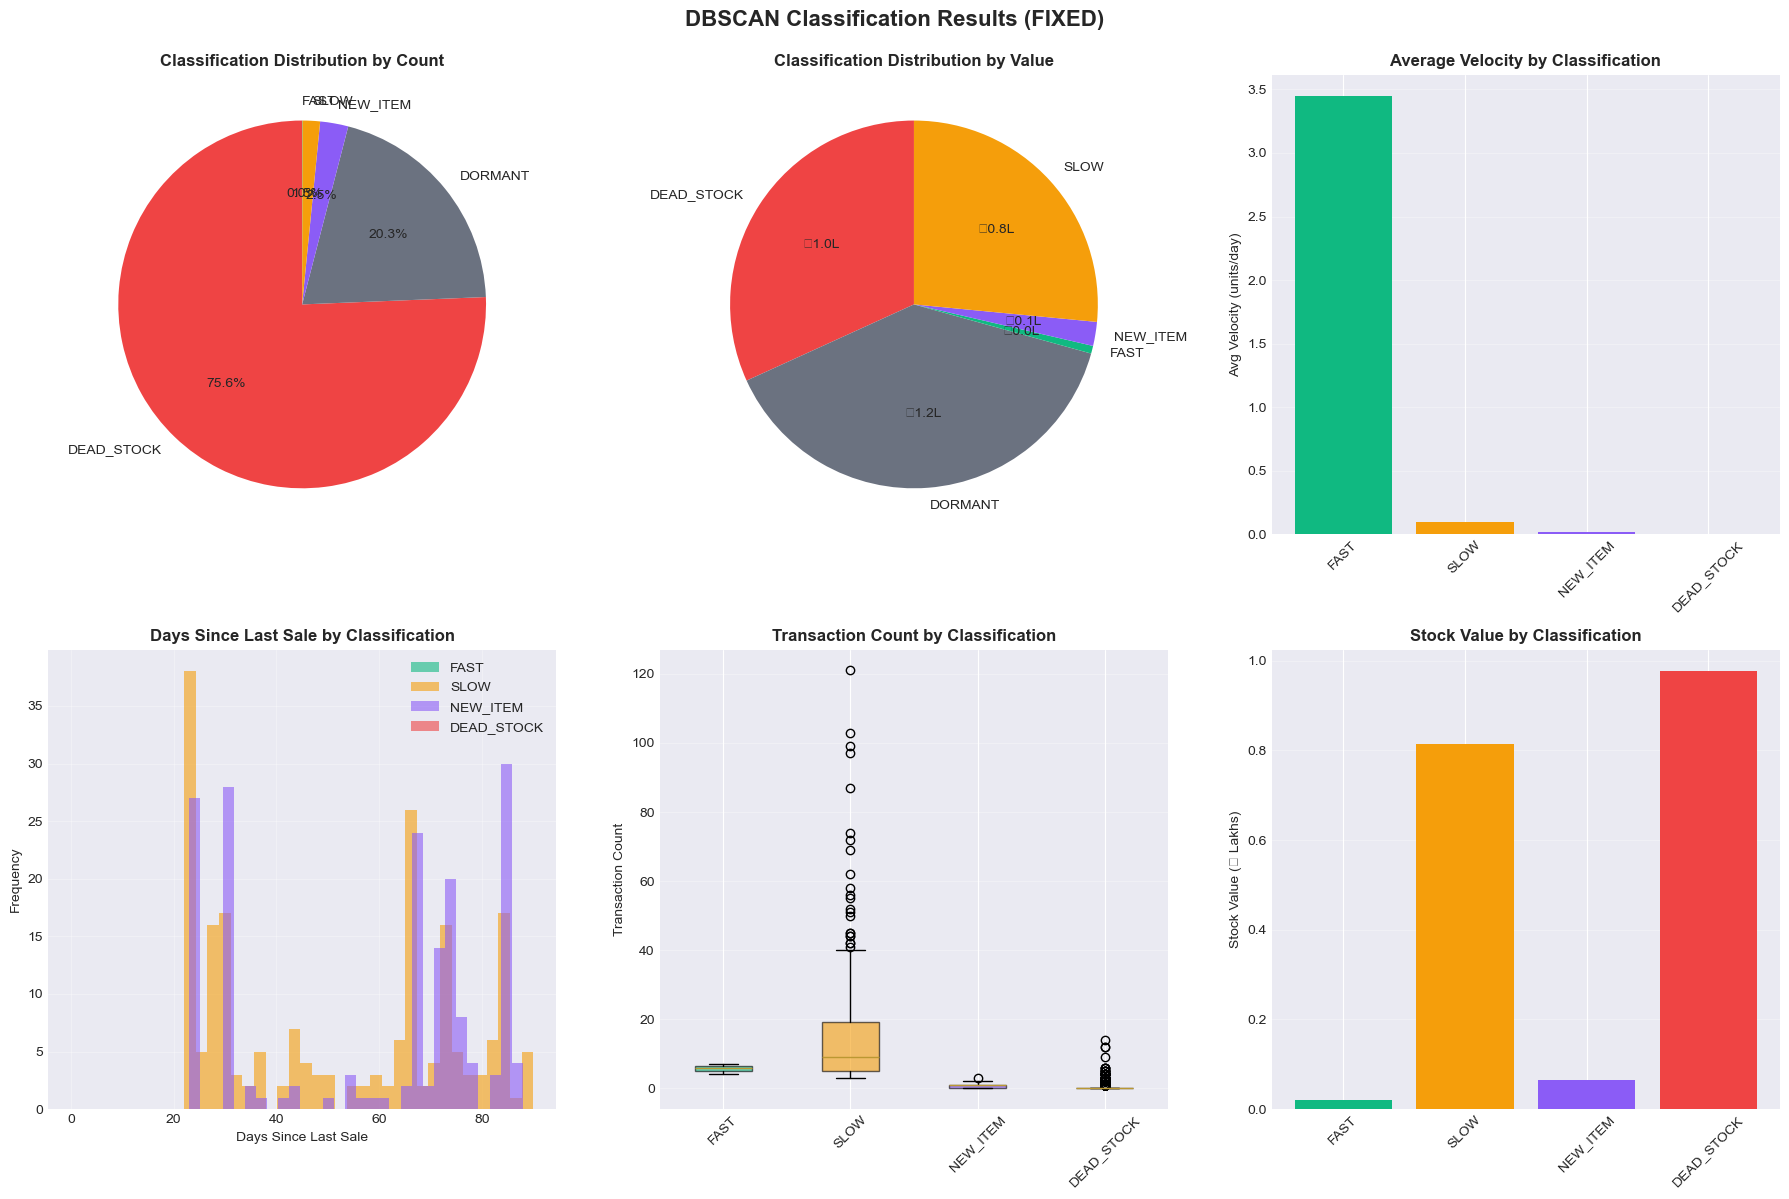


✅ Visualizations saved to /tmp/dbscan_classification_results_fixed.png


In [36]:
# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

colors = {'DEAD_STOCK': '#EF4444', 'NEW_ITEM': '#8B5CF6', 'FAST': '#10B981', 
          'SLOW': '#F59E0B', 'MEDIUM': '#3B82F6'}

# 1. Classification Distribution (Count)
class_counts = df['classification'].value_counts()
colors_list = [colors.get(k, '#6B7280') for k in class_counts.index]
axes[0, 0].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
               colors=colors_list, startangle=90)
axes[0, 0].set_title('Classification Distribution by Count', fontsize=12, fontweight='bold')

# 2. Classification Distribution (Value)
class_values = df.groupby('classification')['stock_value'].sum()
colors_list_val = [colors.get(k, '#6B7280') for k in class_values.index]
axes[0, 1].pie(class_values.values, labels=class_values.index,
               autopct=lambda pct: f'₹{pct/100*class_values.sum()/10_00_000:.1f}L',
               colors=colors_list_val, startangle=90)
axes[0, 1].set_title('Classification Distribution by Value', fontsize=12, fontweight='bold')

# 3. Velocity by Classification
class_order = [c for c in ['FAST', 'SLOW', 'MEDIUM', 'NEW_ITEM', 'DEAD_STOCK'] 
               if c in df['classification'].values]
velocities = [df[df['classification'] == c]['velocity_90d'].mean() for c in class_order]
colors_bar = [colors[c] for c in class_order]

axes[0, 2].bar(range(len(class_order)), velocities, color=colors_bar)
axes[0, 2].set_xticks(range(len(class_order)))
axes[0, 2].set_xticklabels(class_order, rotation=45)
axes[0, 2].set_ylabel('Avg Velocity (units/day)')
axes[0, 2].set_title('Average Velocity by Classification', fontsize=12, fontweight='bold')
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Days Since Last Sale Distribution
for cls in class_order:
    subset = df[df['classification'] == cls]['days_since_last_sale']
    if len(subset) > 0:
        axes[1, 0].hist(subset[subset < 365], bins=30, alpha=0.6,
                       label=cls, color=colors[cls])

axes[1, 0].set_xlabel('Days Since Last Sale')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Days Since Last Sale by Classification', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Transaction Count by Classification
data_box = [df[df['classification'] == cls]['transaction_count'].values 
            for cls in class_order]
colors_box = [colors[cls] for cls in class_order]

bp = axes[1, 1].boxplot(data_box, labels=class_order, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1, 1].set_ylabel('Transaction Count')
axes[1, 1].set_title('Transaction Count by Classification', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Stock Value by Classification
values_by_class = [df[df['classification'] == c]['stock_value'].sum() / 10_00_000 
                   for c in class_order]

axes[1, 2].bar(range(len(class_order)), values_by_class, color=colors_bar)
axes[1, 2].set_xticks(range(len(class_order)))
axes[1, 2].set_xticklabels(class_order, rotation=45)
axes[1, 2].set_ylabel('Stock Value (₹ Lakhs)')
axes[1, 2].set_title('Stock Value by Classification', fontsize=12, fontweight='bold')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.suptitle('DBSCAN Classification Results (FIXED)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/tmp/dbscan_classification_results_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualizations saved to /tmp/dbscan_classification_results_fixed.png")

## 🔟 Save Results

In [37]:
print("\n📤 SAVING CLASSIFICATION RESULTS...\n")

# 1. Complete classification
df.to_csv('/tmp/dbscan_classification.csv', index=False)
print(f"✅ /tmp/dbscan_classification.csv ({len(df):,} items)")

# 2. Pickle
df.to_pickle('/tmp/dbscan_classification.pkl')
print(f"✅ /tmp/dbscan_classification.pkl")

# 3. By classification
for cls in ['DEAD_STOCK', 'NEW_ITEM', 'FAST', 'SLOW', 'MEDIUM']:
    subset = df[df['classification'] == cls]
    if len(subset) > 0:
        filename = f'/tmp/{cls.lower()}_items.csv'
        subset.to_csv(filename, index=False)
        print(f"✅ {filename} ({len(subset):,} items)")

# 4. Active items combined
active_combined = df[df['classification'].isin(['FAST', 'SLOW', 'MEDIUM'])]
if len(active_combined) > 0:
    active_combined.to_csv('/tmp/active_items.csv', index=False)
    print(f"✅ /tmp/active_items.csv ({len(active_combined):,} items)")

# 5. Summary report
summary_data = []
for cls in df['classification'].unique():
    subset = df[df['classification'] == cls]
    summary_data.append({
        'Classification': cls,
        'Count': len(subset),
        'Percentage': f"{len(subset)/len(df)*100:.1f}%",
        'Stock_Value': f"₹{subset['stock_value'].sum():,.0f}",
        'Avg_Velocity': f"{subset['velocity_90d'].mean():.3f}",
        'Avg_Days_No_Sale': f"{subset['days_since_last_sale'].mean():.1f}",
        'Avg_Transactions': f"{subset['transaction_count'].mean():.1f}"
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('/tmp/classification_summary.csv', index=False)
print(f"✅ /tmp/classification_summary.csv")

print("\n" + "="*100)
print("✅ ALL FILES SAVED SUCCESSFULLY")
print("="*100)

print("\n📊 SUMMARY:")
print(summary_df.to_string(index=False))


📤 SAVING CLASSIFICATION RESULTS...

✅ /tmp/dbscan_classification.csv (13,489 items)
✅ /tmp/dbscan_classification.pkl
✅ /tmp/dead_stock_items.csv (10,203 items)
✅ /tmp/new_item_items.csv (333 items)
✅ /tmp/fast_items.csv (3 items)
✅ /tmp/slow_items.csv (208 items)
✅ /tmp/active_items.csv (211 items)
✅ /tmp/classification_summary.csv

✅ ALL FILES SAVED SUCCESSFULLY

📊 SUMMARY:
Classification  Count Percentage Stock_Value Avg_Velocity Avg_Days_No_Sale Avg_Transactions
    DEAD_STOCK  10203      75.6%    ₹976,134        0.000            999.5              0.1
       DORMANT   2742      20.3%  ₹1,193,950        0.001            348.7              3.0
          SLOW    208       1.5%    ₹814,031        0.098             51.6             17.1
      NEW_ITEM    333       2.5%     ₹64,672        0.017            493.6              0.6
          FAST      3       0.0%     ₹20,879        3.444             27.0              5.7


## ✅ Summary

### FIXED Classification Logic:
- **Rule-based first**: Uses business logic (days no sale, age, transactions)
- **DBSCAN for reference**: Provides clustering insights but doesn't drive classification
- **KMeans for FAST/SLOW**: Only applied to ACTIVE items

### Files Created:
1. `dbscan_classification.csv` - Main output
2. `dbscan_classification.pkl` - Faster loading
3. Individual files by classification
4. Summary report

### Next Steps:
Run **Notebook 3** to analyze NEW_ITEM health